# MFM simulations

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


### Importing Packages

In [1]:
%matplotlib notebook
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import random
import matplotlib.pyplot as plt

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [2]:
region = df.Region(p1=(0, 0, 0), p2=(250e-9, 250e-9, 150e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='skl2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

In [3]:
Ms = 384e3

    
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero above the sample,
    Ms inside sample.

    Sample thickness is 50nm.

    """
    x, y, z = pos
    if (z < 50e-9):
        return Ms
    else:
        return 0
    
def m_t_q(pos):
    """
    Function to make a tripple q structure with a period of 50 nm
    
    """
    q = 2*np.pi/(50e-9)
    x, y, z = pos
    
    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

<IPython.core.display.Javascript object>


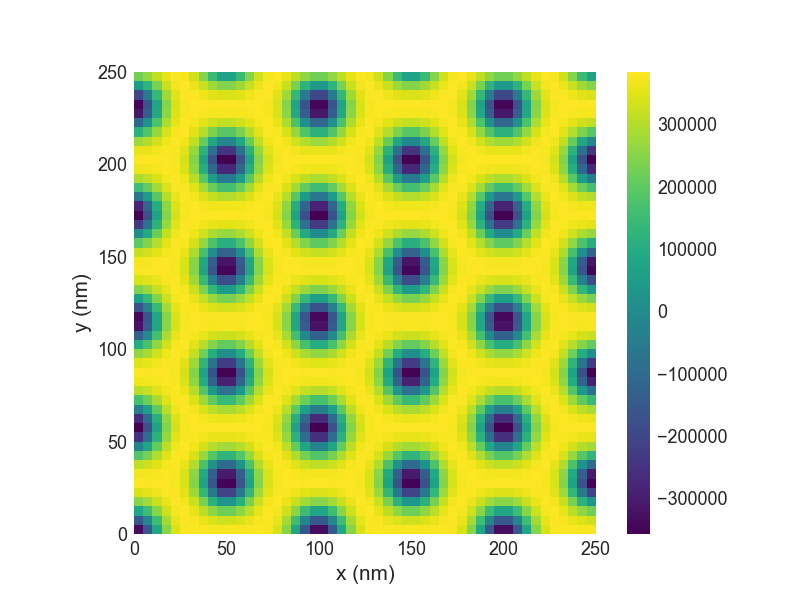

In [4]:
system.m = df.Field(mesh, dim=3, value=m_t_q, norm=Ms_fun)
system.m.z.plane(z=5e-9).mpl()

<IPython.core.display.Javascript object>


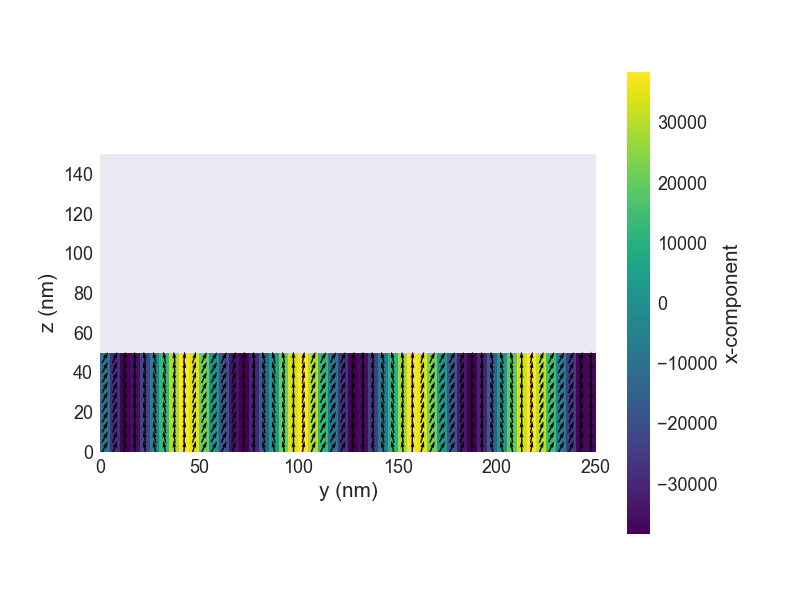

In [5]:
system.m.plane('x').mpl()

In [6]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/06/07 19:04]... (81.7 s)


<IPython.core.display.Javascript object>


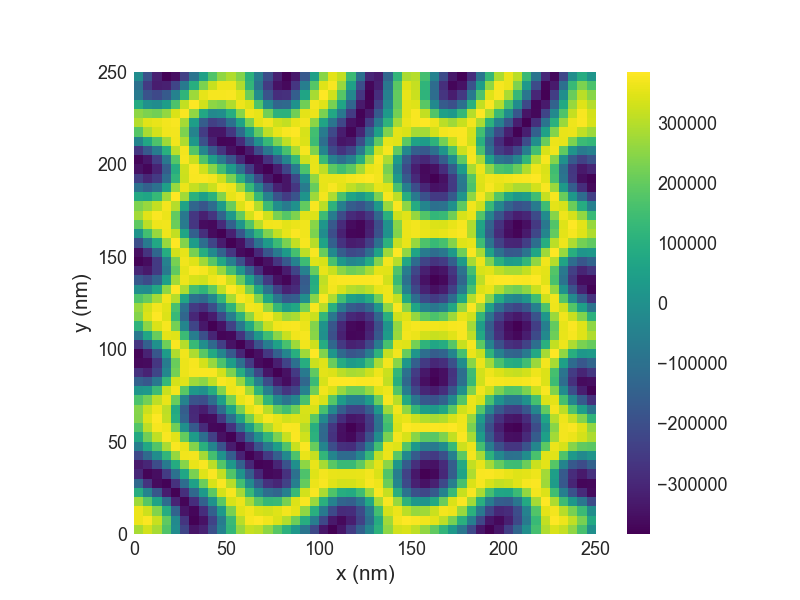

In [7]:
system.m.z.plane(z=5e-9).mpl()

### Stray field

Calculate stray field (does this give the stray field when an external field is also applied?)

In [8]:
stray_field = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (DockerOOMMFRunner) [2021/06/07 19:06]... (4.5 s)


In [9]:
s_x = np.transpose(stray_field.x.array[:,:,:,0], (1,0,2))
s_y = np.transpose(stray_field.y.array[:,:,:,0], (1,0,2))
s_z = np.transpose(stray_field.z.array[:,:,:,0], (1,0,2))

Scan height of 30 nm above the surface (idx = 15)

In [23]:
idx = 13

Q = 650.0
k = 4.0

tip_q = 0#1e-6
tip_m_x = 0# 1e-13
tip_m_y = 0
tip_m_z = 1e-13

h_z_z_1 = (s_z[:,:,idx+1]-s_z[:,:,idx])/system.m.mesh.cell[2] # First derivative of Hz wrt z

h_z_x_2 = (s_x[:,:,idx+1]-2*s_x[:,:,idx]+s_x[:,:,idx-1])/(system.m.mesh.cell[2])**2 # Second derivative of Hx wrt z
h_z_y_2 = (s_y[:,:,idx+1]-2*s_y[:,:,idx]+s_y[:,:,idx-1])/(system.m.mesh.cell[2])**2 # Second derivative of Hy wrt z
h_z_z_2 = (s_z[:,:,idx+1]-2*s_z[:,:,idx]+s_z[:,:,idx-1])/(system.m.mesh.cell[2])**2 # Second derivative of Hz wrt z

phase_shift = (Q*1.256e-6/k)*(tip_q*h_z_z_1+tip_m_x*h_z_x_2+tip_m_y*h_z_y_2+tip_m_z*h_z_z_2)

<IPython.core.display.Javascript object>


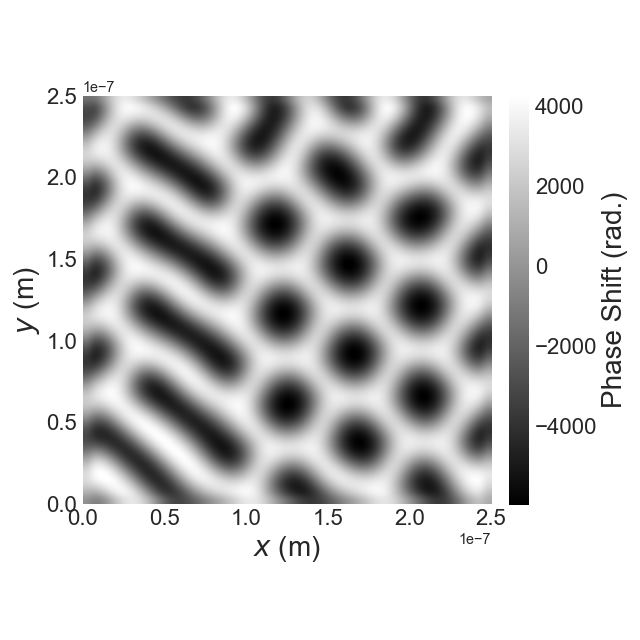

In [25]:
plt.figure(figsize=(8, 8), dpi=80)
imgplot1 = plt.imshow(phase_shift,origin='lower',extent=[system.m.mesh.region.pmin[0], system.m.mesh.region.pmax[0], system.m.mesh.region.pmin[1], system.m.mesh.region.pmax[1]], cmap='gray', interpolation='spline16')
# draw the ellipse
cbar1 = plt.colorbar(imgplot1, fraction=0.046, pad=0.04)
plt.xlabel("$x$ (m)", fontsize=25)
plt.ylabel("$y$ (m)", fontsize=25)
plt.tick_params(labelsize=20)
cbar_lab = cbar1.ax.set_ylabel(r'Phase Shift (rad.)', fontsize=25)
cbar1.ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()

Right image but phase shift seems too large for some reason!?!?!